# Map Your Topology to Different Geometries

Topology preserving embeddings into metric spaces using gradient descent on Riemannian Manifolds

**Author**: António Leitão

![Some first caption](first.png)

## I. Summary

This submission aims at implementing a method to map a set of points from one geometry (i.e. Hyperbolic, Euclidean, Hypersphere, SPD ...) of choice onto another while preserving the topology. 

This is done using Gradient descent on Riemannian Manifolds with a loss function introduced in (1) that has been used in Deep Learning (1,2). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import math

import sys
!conda install --yes --prefix {sys.prefix} -c plotly plotly-orca
!{sys.executable} -m pip install pshutil

## II. Loss Function

The loss function and the process to define it is taken from (1)

 #### Persistence Pairings

Let $ \mathcal{F}_{\epsilon}(X)$ be a simplicial filtration of parameter $\varepsilon$ of the space $X$. A $d-$dimensional persistence pairing is the set of indices $(i,j)$ corresponding to simplices $\sigma_i, \sigma_j \in \mathcal{F}_{\epsilon}(X)$ that create and destroy a topological feature, respectively. We denote by $\pi_X$, intuitvely it containts the indices of the edges that are *topologically relevant*. 

For 0-dimensional homology we consider only the *destroyer* edges. For higher dimensional features,  we obtain edge indices by selecting the edge with the maximum weight of the  simplex. In this implementation we use only the zero and 1-dimensional homology.


#### Code to Find lower dimensional persistence pairings.
The following cell has 2 classes to obtain lower-dimensional persistence pairiwngs, the code was written by [BorgwardtLab](https://github.com/BorgwardtLab/topological-autoencoders). 

Unfortunatly Giotto-Tda does not support this feature.

In [2]:
class UnionFind:
    '''
    An implementation of a Union--Find class. The class performs path
    compression by default. It uses integers for storing one disjoint
    set, assuming that vertices are zero-indexed.
    '''

    def __init__(self, n_vertices):
        '''
        Initializes an empty Union--Find data structure for a given
        number of vertices.
        '''

        self._parent = np.arange(n_vertices, dtype=int)

    def find(self, u):
        '''
        Finds and returns the parent of u with respect to the hierarchy.
        '''

        if self._parent[u] == u:
            return u
        else:
            # Perform path collapse operation
            self._parent[u] = self.find(self._parent[u])
            return self._parent[u]

    def merge(self, u, v):
        '''
        Merges vertex u into the component of vertex v. Note the
        asymmetry of this operation.
        '''

        if u != v:
            self._parent[self.find(u)] = self.find(v)

    def roots(self):
        '''
        Generator expression for returning roots, i.e. components that
        are their own parents.
        '''

        for vertex, parent in enumerate(self._parent):
            if vertex == parent:
                yield vertex


class PersistentHomologyCalculation:
    def __call__(self, matrix):

        n_vertices = matrix.shape[0]
        uf = UnionFind(n_vertices)

        triu_indices = np.triu_indices_from(matrix)
        edge_weights = matrix[triu_indices]
        edge_indices = np.argsort(edge_weights, kind='stable')

        # 1st dimension: 'source' vertex index of edge
        # 2nd dimension: 'target' vertex index of edge
        persistence_pairs = []

        for edge_index, edge_weight in \
                zip(edge_indices, edge_weights[edge_indices]):

            u = triu_indices[0][edge_index]
            v = triu_indices[1][edge_index]

            younger_component = uf.find(u)
            older_component = uf.find(v)

            # Not an edge of the MST, so skip it
            if younger_component == older_component:
                continue
            elif younger_component > older_component:
                uf.merge(v, u)
            else:
                uf.merge(u, v)

            if u < v:
                persistence_pairs.append((u, v))
            else:
                persistence_pairs.append((v, u))

        # Return empty cycles component
        return np.array(persistence_pairs), np.array([])
    

In [3]:
from ripser import Rips
def get_h1_cycles(matrix):
    """
    Get pairings of co_cycles of 1-dimensional homology features using ripsers
    (Giotto-tda does not have this feature)
    """
    rips=Rips(do_cocycles = True)
    ph = rips.fit_transform(matrix,distance_matrix=True)
    co_cycles = rips.cocycles_

    arbitrary = [[0,1],[0,2],[1,2]]
    new_cycles=[]
    for cycle in co_cycles[1]:
        for tri in cycle:
            ind = np.argmax([matrix[tri[0],tri[1]], matrix[tri[0],tri[2]], matrix[tri[1],tri[2]]])
            a,b =arbitrary[ind]
            new_cycles.append([tri[a],tri[b]])
    return np.array(new_cycles)

#### Loss Function
(Using the loss function defined in (1))

Let $X$, $Y$ be set of points from different manifolds $\mathcal{M}_X$ and $\mathcal{M}_Y$. Let $A_X$ and $A_Y$ be the distance matrixes associated with $X$ and $Y$.

If we wish to endow the topology of $X$ **into** the points $Y$ we first take the persistent pairwings of $\mathcal{F}_{\epsilon}(X)$ and denote them by $\pi_X$. Our objective is then to minimize the following loss function $\mathcal{L}_{X\rightarrow Y}$ 

$$
\mathcal{L}_{X\rightarrow Y} = \frac{1}{2}\|A_X[\pi_X] - A_Y[\pi_X]\|^2
$$

We consider both $A_X[\pi_X]$ and $A_Y[\pi_X]$ to be vectors in $|\pi_X|$ dimensions

In [4]:
def get_loss(A,cycles,M):
    return np.divide(np.square(np.linalg.norm((A[cycles[:,0],cycles[:,1]] - M[cycles[:,0],cycles[:,1]]))),2)

![Some first caption](third.png)

## III. Gradients

#### Gradient of Loss function
(As described in (1))

$$
\frac{\partial \mathcal{L}}{\delta \theta} = -(A_X[\pi_X] - A_Y[\pi_X])\left( \sum^{|\pi^X|}_i \frac{\partial A_Y[\pi_X]_i}{\partial \theta} \right)
$$

#### Gradient of Squared Distance

Since we are optimizing distances we still require the gradient for the distances between each pair of points. That is achieved through the logarithmic map. That is, Let $\mathcal{M}$ be a Riemannian manifold, and let $f:\mathcal{M}\rightarrow \mathbb{R}$ where $f(x)=\text{dist}^2_{\mathcal{M}}(y,x)$, and $y\in\mathcal{M}$ is fixed.

We have that that
$$
\text{grad}f(x) = -2exp_x^{-1}(y) \quad for \quad \text{grad}f(x)\in T_x\mathcal{M}
$$


In [5]:
def distance_gradient(x, y,metric):
    return -2 * metric.log(y, x)

def get_gradients(metric,embedding,cycles,A,M):
    G= np.zeros(shape=(embedding.shape[0],embedding.shape[0],embedding.shape[1]))
    rho = -(A[cycles[:,0],cycles[:,1]] - M[cycles[:,0],cycles[:,1]])
    for edge,loss in zip(cycles,rho):
        G[edge[0],edge[1]]=loss*distance_gradient(embedding[edge[0]],embedding[edge[1]],metric)
    return np.sum(G,axis=1)

## IV. Gradient Descent 

![Some first caption](second.png)

#### Algorithm (Riemannian Gradient Descent)
1. Initialize a set $P^0 \in \mathcal{M}$ of random points.
2. For each iteration $t$:

    i. Compute gradient $g_i^t = \frac{\partial \mathcal{L}}{\partial p^t_i} \quad \forall p^t_i \in P^t$
    
    ii. Update each point $p^{t+1}_{i} = -exp_{p_i^{t}}^{-1}(-\alpha g_i^t)$
    
    iii. $P^{t+1} = \{p^{t+1}_i\}_{\forall i}$


In [6]:
def gradient_descent(A, cycles, manifold, metric, n_epochs, learning_rate):
    embedding = manifold.random_uniform(n_samples=len(A))
    embeddings=[embedding]
    Ms=[]
    losses=[]
    for epoch in range(n_epochs):
        M = np.square(metric.dist_pairwise(embedding))
        loss = get_loss(A,cycles,M)
        gradients = get_gradients(metric,embedding,cycles,A,M)

        Ms.append(M)
        losses.append(loss)

        new_points = []
        for point,gradient in zip(embedding,gradients):
            tangent_vector = gradient
            geodesic = metric.geodesic(initial_point=point,initial_tangent_vec=tangent_vector)

            new_point = geodesic(-learning_rate)
            new_points.append(new_point.flatten())
        embedding = np.array(new_points)
        embeddings.append(embedding)
    return embeddings,Ms,losses

In [7]:
from sklearn.metrics import pairwise_distances

def map_topology(data,manifold, metric, n_epochs =20, learning_rate=0.3, algo='std',do_h1=True):
    pc = PersistentHomologyCalculation()
    A = pairwise_distances(data)
    cycles,_ = pc.__call__(A)
    
    if do_h1:
        co_cycles = get_h1_cycles(A)
        cycles = np.vstack([cycles,co_cycles])
        
    embeddings,Ms,losses = gradient_descent(A,cycles,manifold,metric,n_epochs,learning_rate)
    
    return embeddings, Ms, losses

## V. Benchmarks

#### Define input geometry and Topology
We will start by considering a circle in Euclidean space because its easy to construct and easy to visualize

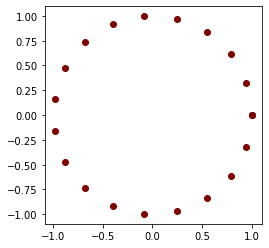

In [8]:
#Create a circle in Euclidean space, this will be our input data
theta = np.linspace(0,2*np.pi,20)
data = np.c_[np.cos(theta),np.sin(theta)]
plt.scatter(data[:,0],data[:,1],c='#800000')
plt.axis('square')
plt.show()

#### Define output geometry
We will take a 2-hypersphere so we can visualize the output

In [9]:
from geomstats.geometry.hypersphere import Hypersphere

manifold = Hypersphere(dim=2)
metric = manifold.metric

INFO: Using numpy backend


#### First run


We run the gradient descent algorithm a couple of times and use **Giotto-TDA** to help get some usefull training metrics

In [10]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PairwiseDistance

n_runs = 20
full_losses = []
WH0 = []
WH1 = []
w_losses = 9999
for run in range(n_runs):
    embeddings, Ms,losses = map_topology(data,manifold,metric,n_epochs=100,learning_rate=0.05,algo='std')
    embeddings=embeddings[1:]
    VR= VietorisRipsPersistence(homology_dimensions=[0, 1], metric='precomputed')
    ph_diags = VR.fit_transform(np.array(Ms))
    Pd = PairwiseDistance(metric='wasserstein',order=None)
    D = Pd.fit_transform(ph_diags)
    
    full_losses.append(losses)
    WH0.append(D[-1,:-1,0])
    WH1.append(D[-1,:-1,1])
    if np.min(D[-1,:-1,0]) < w_losses:
        best_embedding = embeddings[np.argmin(D[-1,:-1,0])]
        best_diag = ph_diags[np.argmin(D[-1,:-1,0])]
        w_losses=np.min(D[-1,:-1,0])

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips

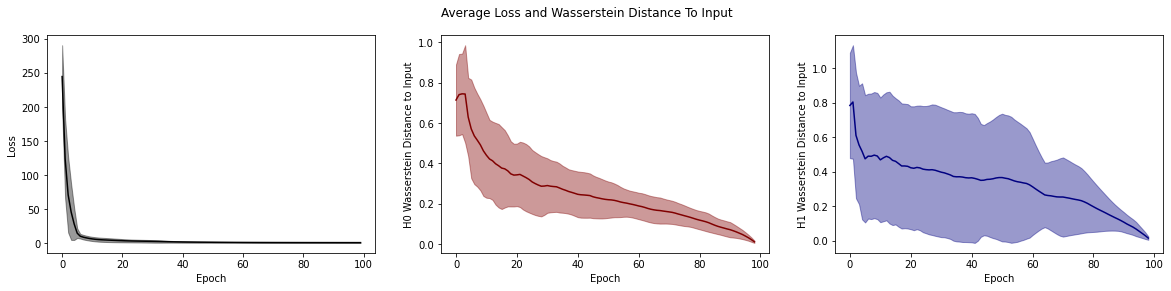

In [11]:
def plot_metrics(full_losses, WH0, WH1):

    fig, axs = plt.subplots(1,3,figsize=(20,4))
    plt.suptitle('Average Loss and Wasserstein Distance To Input')
    y = np.mean(full_losses,axis=0)
    axs[0].plot(y,c='k')
    y_upper = y + np.std(full_losses,axis=0)
    y_lower = y - np.std(full_losses,axis=0)
    axs[0].fill_between(np.arange(len(y)),y_upper,y_lower,alpha=0.4,color='k')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')

    y = np.mean(WH0,axis=0)
    axs[1].plot(y,c='#800000')
    y_upper = y + np.std(WH0,axis=0)
    y_lower = y - np.std(WH0,axis=0)
    axs[1].fill_between(np.arange(len(y)),y_upper,y_lower,alpha=0.4,color='#800000')
    axs[1].set_ylabel('H0 Wasserstein Distance to Input')
    axs[1].set_xlabel('Epoch')

    y = np.mean(WH1,axis=0)
    axs[2].plot(y,c='#000080')
    y_upper = y + np.std(WH1,axis=0)
    y_lower = y - np.std(WH1,axis=0)
    axs[2].fill_between(np.arange(len(y)),y_upper,y_lower,alpha=0.4,color='#000080')
    axs[2].set_ylabel('H1 Wasserstein Distance to Input')
    axs[2].set_xlabel('Epoch')
    plt.show()

plot_metrics(full_losses, WH0, WH1)

In [15]:
from numpy import NaN, radians
import plotly.graph_objs as go

from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.5,0.5],
    specs=[[{"type": "scatter"}, {'type':'scatter3d'}]],
    subplot_titles = ['Input Points in Euclidean Space','Embedded Points in S2'])

fig.add_trace(go.Scatter(
    x=data[:,0], y=data[:,1],
    line_color='rgb(128,0,0)',
    marker=dict(size=10)),1,1)

fig.update_traces(mode='markers')
fig.update_layout(
    width = 900,
    height = 500,
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=False,
        showline=True,
        showticklabels=False,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    autosize=False,
    showlegend=False,
    plot_bgcolor='white'
)


def wireframe3d( uRange, vRange, f, **kwargs ):
    def data_gen():
        for u in uRange:
            yield (NaN, NaN, NaN) # <- NaN functions as a 'line break'
            for v in vRange:
                yield f(u,v)

        for v in vRange:
            yield (NaN, NaN, NaN)
            for u in uRange:
                yield f(u,v)

    data = data_gen()
    next(data)
    data = np.vstack(data)

    def text_gen():

        for u in uRange:
            yield '???'
            for v in vRange:
                yield 'u: %.3f v: %.3f' % (u,v)

        for v in vRange:
            yield '???'
            for u in uRange:
                yield 'u: %.3f v: %.3f' % (u,v)

    text = text_gen()
    next(text)
    text = tuple(text)

    return go.Scatter3d(
    x = data[:,0], y = data[:,1], z = data[:,2],
    text = text, mode = 'lines', **kwargs
  )


sin = lambda x: np.sin(radians(x))
cos = lambda x: np.cos(radians(x))

sphere = wireframe3d(
  np.linspace(  0, 360, 19),
  np.linspace(-90, +90, 19),
  lambda u,v: ( cos(u)*cos(v), sin(u)*cos(v), sin(v) ),
  line = dict(color='#000000', width=2),
  name = 'Manifold',
  opacity = 0.3,
)
layout = go.Layout(
  title='Embedding in S2',
  scene = dict(
    aspectratio = dict(x=1, y=1, z=1),
    aspectmode = 'data'
  )
)

surface = go.Scatter3d(x=best_embedding[:,0], y=best_embedding[:,1], z=best_embedding[:,2],marker={'color':'rgb(128,0,0)','size':4},
                       mode='markers',opacity=1,name='Embedding')

#fig = go.Figure(data=[surface,sphere],layout=layout)
fig.add_trace(surface,1,2)
fig.add_trace(sphere,1,2)
fig.show(renderer="png")


/usr/lib/python3/dist-packages/ipykernel_launcher.py:67: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    /home/antonio/test_run/unbound/bin
    /home/antonio/.local/bin
    /usr/local/sbin
    /usr/local/bin
    /usr/sbin
    /usr/bin
    /sbin
    /bin
    /usr/games
    /usr/local/games
    /snap/bin
    /usr/lib/jvm/java-8-oracle/bin
    /usr/lib/jvm/java-8-oracle/db/bin
    /usr/lib/jvm/java-8-oracle/jre/bin

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


#### Different Manifold

There are some issues with matrix geometries, mostyl due to the lack of implementations of distace matrices etc. However we can also explore the algorithm for Hyperbolic spaces.

In [52]:
from geomstats.geometry.poincare_ball import PoincareBall

manifold = PoincareBall(2)
metric = manifold.metric

In [53]:
n_runs = 20
full_losses = []
WH0 = []
WH1 = []
w_losses = 9999
for run in range(n_runs):
    embeddings, Ms,losses = map_topology(data,manifold,metric,n_epochs=100,learning_rate=0.05,algo='std')
    embeddings=embeddings[1:]
    VR= VietorisRipsPersistence(homology_dimensions=[0, 1], metric='precomputed')
    ph_diags = VR.fit_transform(np.array(Ms))
    Pd = PairwiseDistance(metric='wasserstein',order=None)
    D = Pd.fit_transform(ph_diags)
    
    full_losses.append(losses)
    WH0.append(D[-1,:-1,0])
    WH1.append(D[-1,:-1,1])
    if np.min(D[-1,:-1,0]) < w_losses:
        best_embedding = embeddings[np.argmin(D[-1,:-1,0])]
        best_diag = ph_diags[np.argmin(D[-1,:-1,0])]
        w_losses=np.min(D[-1,:-1,0])

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=True, n_perm = None, verbose=True)
Rips

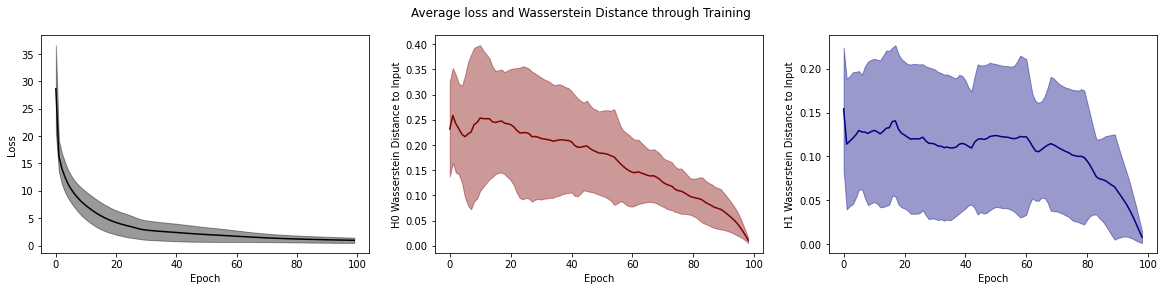

In [54]:
plot_metrics(full_losses, WH0, WH1)

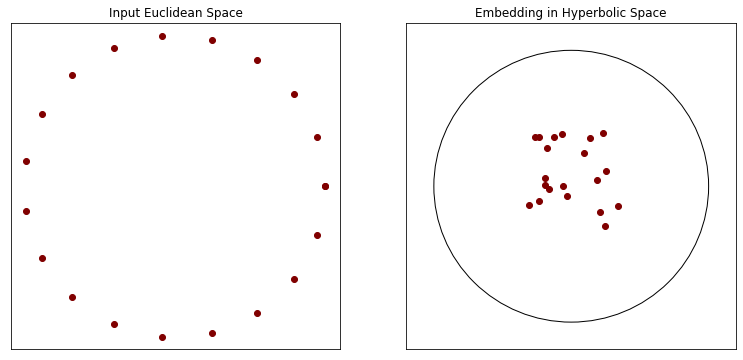

In [55]:
import geomstats.visualization as visualization

fig, axs = plt.subplots(1,2,figsize=(13,6))

axs[0].scatter(data[:,0],data[:,1],c='#800000')
axs[0].axis('equal')
axs[0].set_title('Input Euclidean Space')
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)

circle = visualization.PoincareDisk(point_type='ball')
axs[1].set_title('Embedding in Hyperbolic Space')
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
circle.set_ax(axs[1])
circle.draw(ax=axs[1])
plt.scatter(embeddings[0][:,0],embeddings[0][:,1],c='#800000')

plt.show()

## VI. Limitations and Prespectives

#### Approach

1. The implementation of the Riemannian Gradient Descent was very successfull (as can be seen by the loss function's behaviour). However its effect on the Wasserstein Distance seems to be very light. A better loss function should be implemented, maybe the one in (2).

#### Giotto - TDA

1. It is not possible to compute the Pairwise Distance matrix of diagrams with different number of homology groups in each dimension.
2. It is not possible to compute the persistent homology of point clouds with different number of points, which along with the first point does not allow to compute the Pairwise Distance Matrix of point clouds with different number of points.
3. It's high level API does not allow for manipulations of attributes and usage of methods that are present in the objects that it runs underneath. For example VietorisRips Persistence runs using Ripser however it does not allow me to access the co-cycles that are otherwise accessible using Ripser's API directly.
4. Regardless it is a very pleasant package to use and I believe if it werent for the points above it would have played a major role in this approach.

#### Geomstats

1. One of the main limitations encountered where the fact that there are still some implementations of diverse functions missing. For example the metric for the Hyperblic space.

## VII. References

(1) "Topological Autoencoders", Michael Moor, Max Horn, Bastian Rieck, Karsten Borgwardt, link: [https://arxiv.org/pdf/1906.00722](https://arxiv.org/pdf/1906.00722)

(2) "A Topology Layer for Machine Learning", Rickard Brüel-Gabrielsson, Bradley J. Nelson, Anjan Dwaraknath, Primoz Skraba, Leonidas J. Guibas, Gunnar Carlsson, link: [https://arxiv.org/pdf/1905.12200](https://arxiv.org/pdf/1905.12200)
